Matt Thomas

met8k@virginia.edu 

DS5001 

4/30/20

In [25]:
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

### Setup

In [42]:
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()
emo = 'polarity'
OHCO = ['doc_source', 'doc_id', 'sent_num']

In [5]:
salex = pd.read_csv('../M10/salex_nrc.csv').set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]

In [7]:
salex['polarity'] = salex.positive - salex.negative

In [9]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [17]:
TOKEN = pd.read_csv('TOKEN2.csv').set_index(OHCO[:2])

In [18]:
TOKEN = TOKEN.join(salex, on='term_str', how='left')
TOKEN[emo_cols] = TOKEN[emo_cols].fillna(0)

In [72]:
TOKEN.head()

sent_num  token_num    token  pos term_str  term_id  anger  \
doc_source doc_id                                                               
PowerLine  48             1          1     I’ve  VBN      ive    81029    0.0   
           48             1          3  falling   IN  falling    56838    0.0   
           48             1          4   behind   IN   behind    17571    0.0   
           48             1          6     many   JJ     many    94015    0.0   
           48             1          7  regular  NNS  regular   127233    0.0   

                   anticipation  disgust  fear  joy  negative  positive  \
doc_source doc_id                                                         
PowerLine  48               0.0      0.0   0.0  0.0       NaN       NaN   
           48               0.0      0.0   0.0  0.0       1.0       0.0   
           48               0.0      0.0   0.0  0.0       NaN       NaN   
           48               0.0      0.0   0.0  0.0       NaN       NaN   
           48               0.0      0.0   0.0  0.0       NaN       NaN   

                   sadness  surprise  trust  polarity  
doc_source doc_id                                      
PowerLine  48          0.0       0.0    0.0       0.0  
           48          1.0       0.0    0.0      -1.0  
           48          0.0       0.0    0.0       0.0  
           48          0.0       0.0    0.0       0.0  
           48          0.0       0.0    0.0       0.0

### Find Sentiments in Each News Source

In [21]:
powerline = TOKEN.loc['PowerLine'].copy()
kos = TOKEN.loc['Daily Kos'].copy()
politico = TOKEN.loc['Politico Magazine'].copy()

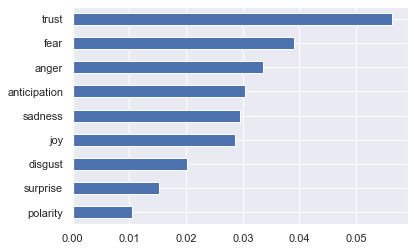

In [29]:
powerline[emo_cols].mean().sort_values().plot.barh()

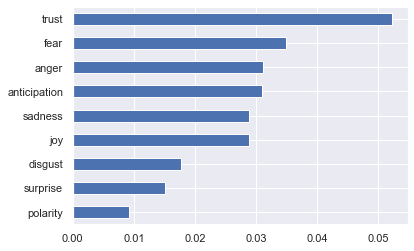

In [27]:
kos[emo_cols].mean().sort_values().plot.barh()

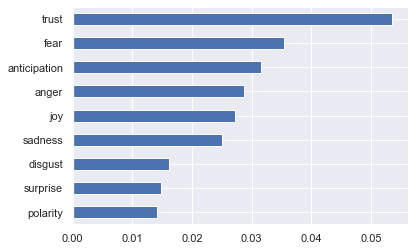

In [28]:
politico[emo_cols].mean().sort_values().plot.barh()

Daily Kos and PowerLine have more anger

### Apply Vader

In [33]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/matthewthomas/nltk_data...


True

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [45]:
powerline_sents = powerline.groupby(OHCO[1:3])[emo_cols].mean()
kos_sents = kos.groupby(OHCO[1:3])[emo_cols].mean()
politico_sents = politico.groupby(OHCO[1:3])[emo_cols].mean()

In [47]:
powerline_sents['sent_str'] = powerline.groupby(OHCO[1:3]).term_str.apply(lambda x: x.str.cat(sep=' '))
kos_sents['sent_str'] = kos.groupby(OHCO[1:3]).term_str.apply(lambda x: x.str.cat(sep=' '))
politico_sents['sent_str'] = politico.groupby(OHCO[1:3]).term_str.apply(lambda x: x.str.cat(sep=' '))

In [48]:
powerline_vader_cols = powerline_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
powerline_vader = pd.concat([powerline_sents, powerline_vader_cols], axis=1)
kos_vader_cols = kos_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
kos_vader = pd.concat([kos_sents, kos_vader_cols], axis=1)
politico_vader_cols = politico_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
politico_vader = pd.concat([politico_sents, politico_vader_cols], axis=1)

In [56]:
LIB = pd.read_csv('LIBRARY.csv')
dates = dict(zip(LIB.doc_id, LIB.doc_date))

In [65]:
#Index by date so that we can track sentiment over time
powerline_vader = powerline_vader.reset_index()
powerline_vader['doc_date'] = powerline_vader.doc_id.map(dates)
powerline_vader = powerline_vader.set_index(['doc_date'])

In [66]:
kos_vader = kos_vader.reset_index()
kos_vader['doc_date'] = kos_vader.doc_id.map(dates)
kos_vader = kos_vader.set_index(['doc_date'])
politico_vader = politico_vader.reset_index()
politico_vader['doc_date'] = politico_vader.doc_id.map(dates)
politico_vader = politico_vader.set_index(['doc_date'])

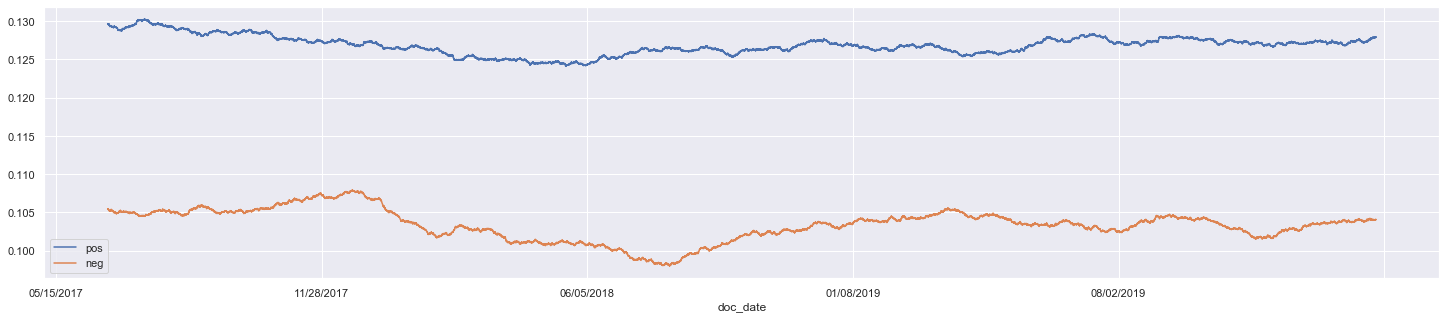

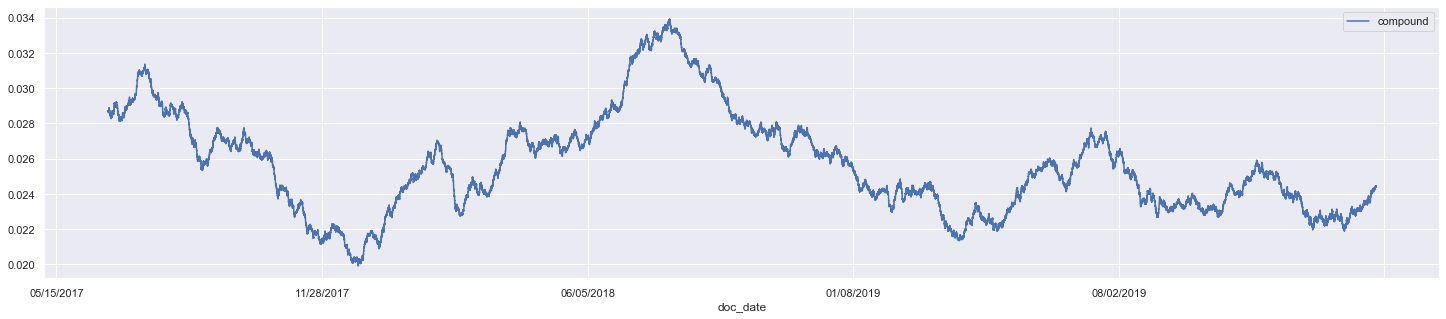

In [67]:
w = int(powerline_vader.shape[0] / 5)
powerline_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5))
powerline_vader[['compound']].rolling(w).mean().plot(figsize=(25,5))

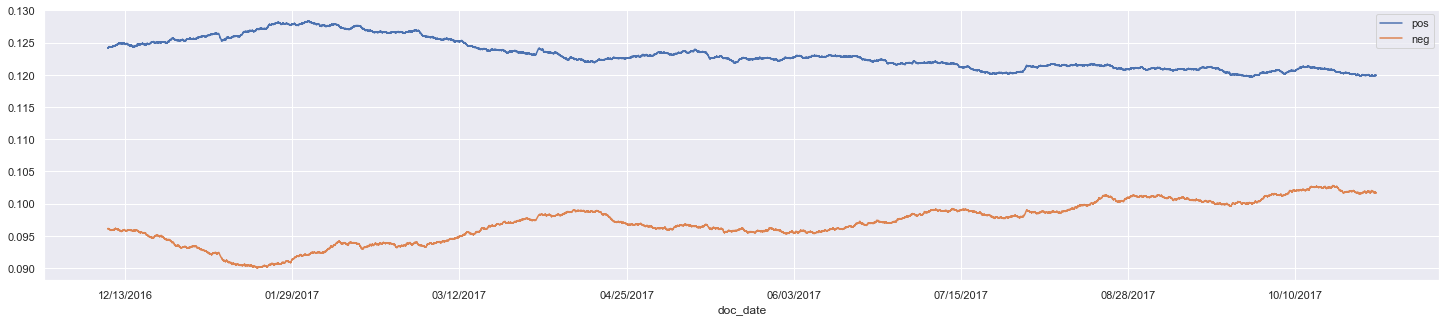

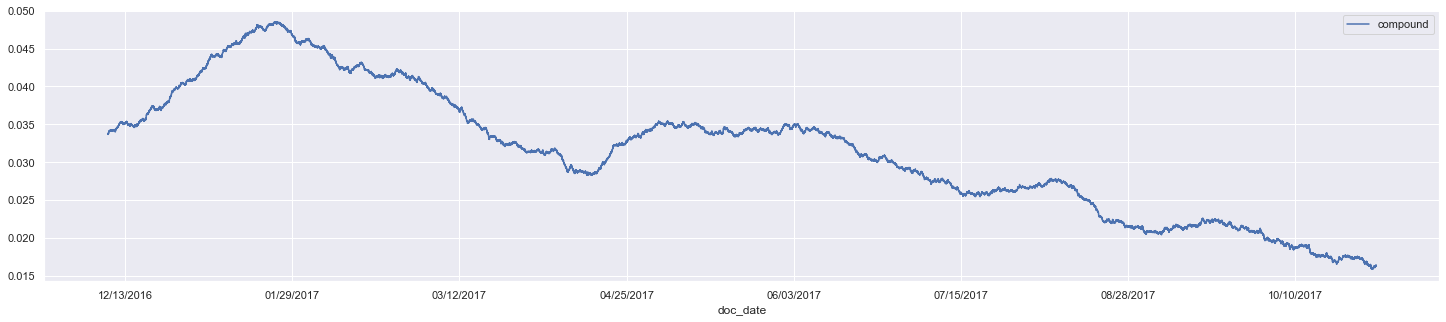

In [68]:
w = int(kos_vader.shape[0] / 5)
kos_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5))
kos_vader[['compound']].rolling(w).mean().plot(figsize=(25,5))

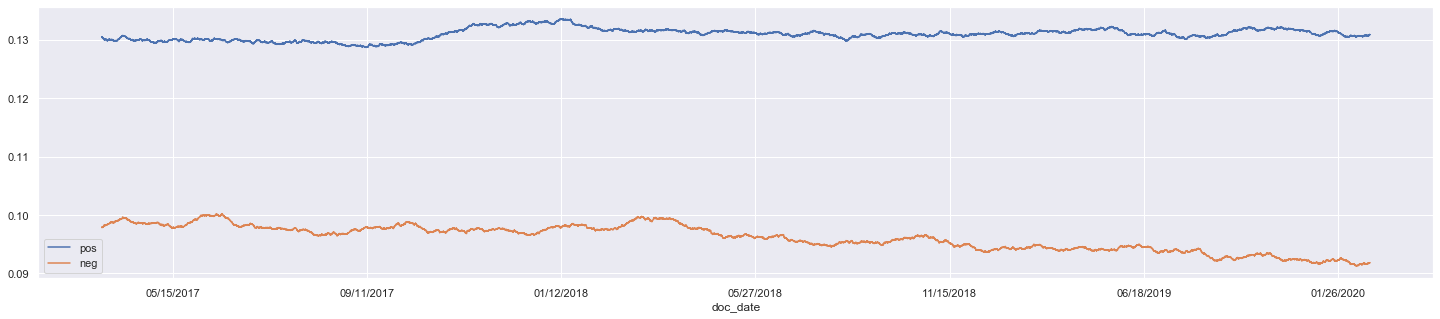

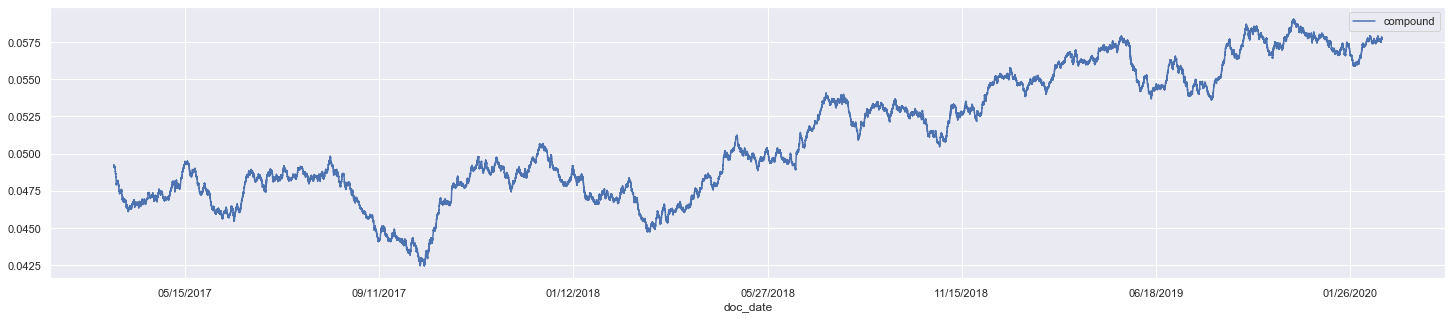

In [69]:
w = int(politico_vader.shape[0] / 5)
politico_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5))
politico_vader[['compound']].rolling(w).mean().plot(figsize=(25,5))

### Save Sentiments per Term String and Document to CSV

In [82]:
SENTIMENT_VOCAB = TOKEN.drop(['token', 'token_num', 'sent_num'], axis=1).reset_index()

In [88]:
SENTIMENT_VOCAB = SENTIMENT_VOCAB.groupby('term_str')[emo_cols].mean()

In [90]:
VOCAB = pd.read_csv('VOCAB2.csv', index_col='term_str')

In [92]:
SENTIMENT_VOCAB = SENTIMENT_VOCAB[SENTIMENT_VOCAB.index.isin(VOCAB.index)]

In [98]:
SENTIMENT_VOCAB.sample(10)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity
term_str,,,,,,,,,
destruction,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
underwater,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
disguising,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
introductory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
supplied,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
governed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gripped,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
speculated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
SENTIMENT_VOCAB.to_csv('SENTIMENT_VOCAB.csv')

In [101]:
SENTIMENT_DOC = pd.concat([powerline_vader, kos_vader, politico_vader])

In [103]:
vader_emos = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', \
             'polarity', 'neg', 'neu', 'pos', 'compound']

In [104]:
#Aggregate sentiments for each document
SENTIMENT_DOC = SENTIMENT_DOC.reset_index().groupby('doc_id')[vader_emos].mean()

In [105]:
SENTIMENT_DOC

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity,neg,neu,pos,compound
doc_id,,,,,,,,,,,,,
48,0.000000,0.000000,0.000000,0.000000,0.000000,0.007407,0.000000,0.035185,0.027778,0.011444,0.953222,0.035333,0.053756
49,0.011138,0.034244,0.002841,0.006088,0.027561,0.004464,0.009334,0.057729,0.044968,0.062955,0.803864,0.133182,-0.007705
50,0.063294,0.058333,0.084127,0.072222,0.012941,0.075794,0.005556,0.034608,-0.057852,0.161650,0.691350,0.146950,-0.019310
51,0.059291,0.022661,0.059291,0.008772,0.008772,0.045402,0.000000,0.026316,-0.019086,0.195833,0.647167,0.157167,-0.146033
52,0.072370,0.034263,0.066696,0.097193,0.035002,0.076001,0.010165,0.038091,-0.053174,0.169894,0.683021,0.147021,0.043866
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026329,0.014931,0.027019,0.019560,0.025242,0.025835,0.012626,0.006566,0.030863,0.016301,0.038500,0.754667,0.206875,0.243838
1026330,0.073592,0.064016,0.026558,0.088295,0.014923,0.047718,0.004506,0.074018,0.005681,0.118475,0.731100,0.125375,0.052855
1026331,0.041994,0.047986,0.048947,0.108198,0.016504,0.063599,0.016667,0.034097,-0.059286,0.126833,0.731556,0.141611,-0.064606


In [108]:
TOKEN = TOKEN.reset_index()
sources = dict(zip(TOKEN.doc_id, TOKEN.doc_source))

In [112]:
SENTIMENT_DOC = SENTIMENT_DOC.reset_index()
SENTIMENT_DOC['doc_source'] = SENTIMENT_DOC.doc_id.map(sources)

In [115]:
SENTIMENT_DOC.sample(15)

,doc_id,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity,neg,neu,pos,compound,doc_source
20587,662486,0.018473,0.020259,0.004926,0.017297,0.036987,0.018268,0.020567,0.066989,0.031240,0.085345,0.768379,0.146241,0.078021,PowerLine
2636,28021,0.016156,0.016156,0.045918,0.016156,0.023675,0.035714,0.013471,0.047485,0.053437,0.015857,0.826571,0.157571,0.271971,PowerLine
14784,271192,0.042424,0.062879,0.016667,0.042424,0.042424,0.068182,0.000000,0.042424,-0.043939,0.117000,0.798636,0.084545,-0.039400,PowerLine
19449,570747,0.046316,0.023211,0.019918,0.072095,0.007173,0.045802,0.013599,0.042403,-0.030883,0.106043,0.848851,0.023851,-0.178655,PowerLine
5532,66548,0.044881,0.019769,0.028571,0.074562,0.038109,0.055172,0.012261,0.064268,0.005217,0.154414,0.704259,0.141328,-0.041819,Daily Kos
17344,408214,0.052886,0.017069,0.043231,0.064303,0.023363,0.035370,0.009361,0.050838,-0.021675,0.126333,0.782000,0.091667,-0.118118,PowerLine
13865,248857,0.036104,0.022517,0.024433,0.044172,0.023844,0.025245,0.009185,0.060371,0.005845,0.146913,0.683290,0.169812,0.036116,Politico Magazine
9775,159058,0.000000,0.005917,0.000000,0.005917,0.003077,0.012821,0.000000,0.015385,0.005641,0.030385,0.748615,0.221000,0.282185,PowerLine
6358,85405,0.017787,0.012549,0.010758,0.023449,0.016713,0.015910,0.011070,0.032217,0.008003,0.079384,0.784753,0.108452,0.028853,Daily Kos
17442,414832,0.000000,0.012622,0.000000,0.011538,0.028610,0.023279,0.007692,0.045150,0.018227,0.081692,0.820385,0.097923,0.089323,PowerLine


In [116]:
SENTIMENT_DOC = SENTIMENT_DOC.set_index(['doc_source', 'doc_id'])

In [117]:
SENTIMENT_DOC.to_csv('SENTIMENT_DOC.csv')